**Reconocimiento de Neumonía con imágenes de radiografias**

***Grupo 04***

***Andrés Viñé Sánchez, Beatriz Aedo Díaz, Candela Esquinas Sánchez, José Antonio Ruiz Heredia***

**1. Importación de librerías y datos**

In [20]:
# TensorFlow 
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Otros
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import glob
import random
import cv2

Rutas de datos específicas de nuestro ordenador.

Cambiar la ruta dependiendo de donde tengas los datos.

In [21]:
# Rutas de datos
TRAIN_DATASET = "C:\src\Personal\SI\Chest_X_Ray_Pneumonia_Detection\Dataset\Train"
TEST_DATASET = "C:\src\Personal\SI\Chest_X_Ray_Pneumonia_Detection\Dataset\Test"
VAL_DATASET = "C:\src\Personal\SI\Chest_X_Ray_Pneumonia_Detection\Dataset\Val"

# Nuevas rutas
CSV_DATSET = "C:\src\Personal\SI\Chest_X_Ray_Pneumonia_Detection\Dataset"

In [22]:
folder_paths = [TRAIN_DATASET, TEST_DATASET, VAL_DATASET]

**2. Cargar y etiquetar datos**

Primero definimos las etiquetas y las columnas de nuestro csv

In [23]:
# Categorías
category_label = ["Normal", "Pneumonia"]
data_label = ["Train", "Test", "Val"]

# Columnas del csv
headers = ["image_path", "image_name", "category_index", "category_label", "data_index", "data_label"]

Métodos auxiliares para asignar etiquetas y escribir el csv

In [24]:
# Devuelve la etiqueta asociada al índice de la categoría
def getCategory(index):
    category_type_label = category_label[index]
    return category_type_label

def getType(index):
    data_type_label= data_label[index]
    return data_type_label

# Escribimos una fila en el csv
def write(writer, file_path, file_name, category_index, category_label, data_type_index, data_type_label):
    writer.writerow([
        file_path,
        file_name, 
        category_index, 
        category_label, 
        data_type_index,
        data_type_label
    ])
                    

Método principal para recorrer nuestros archivos y etiquetar nuestro dataset

In [25]:
# Cargo las rutas de mis archivos
labeled_dataset_path = os.path.join(CSV_DATSET, 'labeled_dataset.csv')
with open(labeled_dataset_path, 'w', newline='') as csvfile:
    
  # Escribimos los títulos de las columnas
  writer = csv.writer(csvfile, delimiter=',')
  writer.writerow(i for i in headers)

  # Recorremos cada tipo de dato (TEST, TRAIN, VAL)
  for data_type_index, data_type_folder in enumerate(folder_paths):   

      # Recorremos cada categoría (NORMAL, PNEUMONIA) dentro de la carpeta actual
      for category_type_index, category_type_label in enumerate(category_label): 
          category_type_folder = os.path.join(data_type_folder, category_type_label)

          # Recorremos todos los archivos dentro de la categoría
          for root, _, files in os.walk(category_type_folder):
            for file in files:
                
                # Guardamos si es un archivo JPEG
                if file.endswith(".jpeg"):
                  file_path = os.path.join(root, file)
                  file_name, _ = os.path.splitext(file)
                  
                  category_type_label = getCategory(category_type_index)
                  data_type_label = getType(data_type_index)
                  
                  write(writer, file_path, file_name, category_type_index, category_type_label, data_type_index, data_type_label)

***3. Pre-procesado de los datos***

In [26]:
# Diccionarios para contar la cantidad de datos por categoría y tipo
category_type_count = {'Normal': 0, 'Pneumonia': 0}
data_type_count = {'Train': 0, 'Test': 0, 'Val': 0}

# Abrimos en modo lectura el CSV 
with open(labeled_dataset_path, 'r') as csvfile:
    csvreader = csv.DictReader(csvfile)
    for row in csvreader:
        # Incrementamos el contador según la categoría
        category_type_count[row['category_label']] += 1
        
        # Incrementamos el contador según el tipo
        data_type_count[row['data_label']] += 1

In [27]:
# Mostrar los resultados
print("Cantidad de datos por categoría:")
for category_type, category_count in category_type_count.items():
    print(f"{category_type}: {category_count}")

print("\nCantidad de datos por tipo:")
for data_type, data_count in data_type_count.items():
    print(f"{data_type}: {data_count}")

Cantidad de datos por categoría:
Normal: 1583
Pneumonia: 4273

Cantidad de datos por tipo:
Train: 5216
Test: 624
Val: 16


Se puede observar un desequilibrio en el tamaño de las imágenes de neumonía respecto a las normales.

Este ``desequilibrio`` puede afectar el rendimiento del modelo, por lo que posteriormente podemos realizar una prueba equiparando ambos conjuntos de datos.

In [28]:
categories = list(category_type_count.keys())
category_counts = list(category_type_count.values())
data_types = list(data_type_count.keys())
data_counts = list(data_type_count.values())

# Definimos los colores para las barras
colors_category = ['blue', 'orange']
colors_data = ['lightgreen', 'skyblue', 'red']

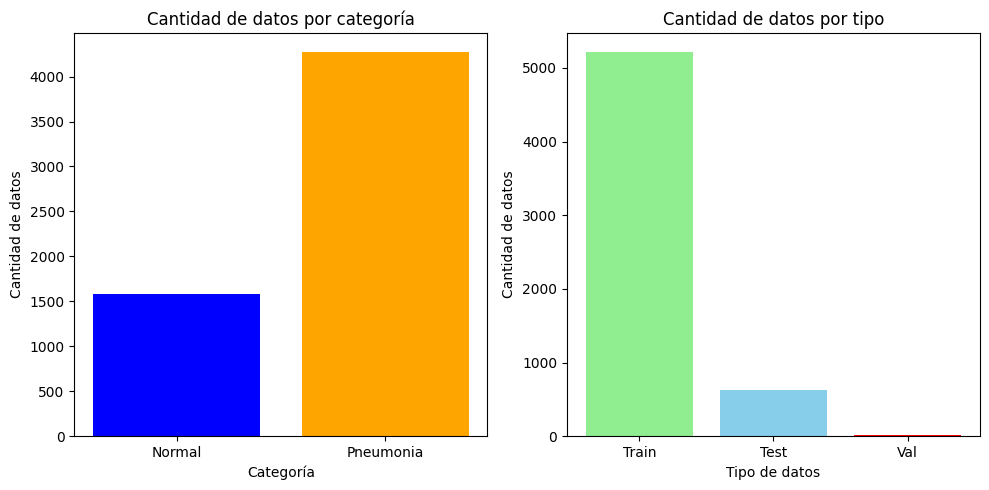

In [29]:
# Creamos un gráfico de barras para la categoría
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(categories, category_counts, color=colors_category)
plt.title('Cantidad de datos por categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de datos')

# Creamos un gráfico de barras para el tipo
plt.subplot(1, 2, 2)
plt.bar(data_types, data_counts, color=colors_data)
plt.title('Cantidad de datos por tipo')
plt.xlabel('Tipo de datos')
plt.ylabel('Cantidad de datos')

# Mostramos el gráfico
plt.tight_layout()
plt.show()

Cargamos todas las rutas de imágenes en dos dataframes divididos en ``Pneumonia`` y ``Normal``

In [30]:
# Cargar el archivo CSV
df = pd.read_csv(labeled_dataset_path)  

# Guardamos dos dataframes distintos por categoria
normal_images_df = df[df['category_label'] == 'Normal']
pneumonia_images_df = df[df['category_label'] == 'Pneumonia']

# Obtener las rutas de las imágenes
normal_train_images = normal_images_df['image_path'].tolist()
pneumonia_train_images = pneumonia_images_df['image_path'].tolist()

Métodos de preprocesado de imágenes

In [31]:
# Función para redimensionar una imagen
def resize_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

# Función para aplicar filtros de suavizado y corrección de contraste
def preprocess_image(image, blur, contraste, grid):
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicar filtro de suavizado (filtro de mediana) para reducir el ruido
    smooth_img = cv2.medianBlur(gray_img, blur)
    
    # Aplicar corrección de contraste
    clahe = cv2.createCLAHE(clipLimit = contraste, tileGridSize=(grid,grid))
    contrast_img = clahe.apply(smooth_img)
    
    return contrast_img

Estudiamos como se aplican distintos formatos de ``resize`` a nuestras imágenes

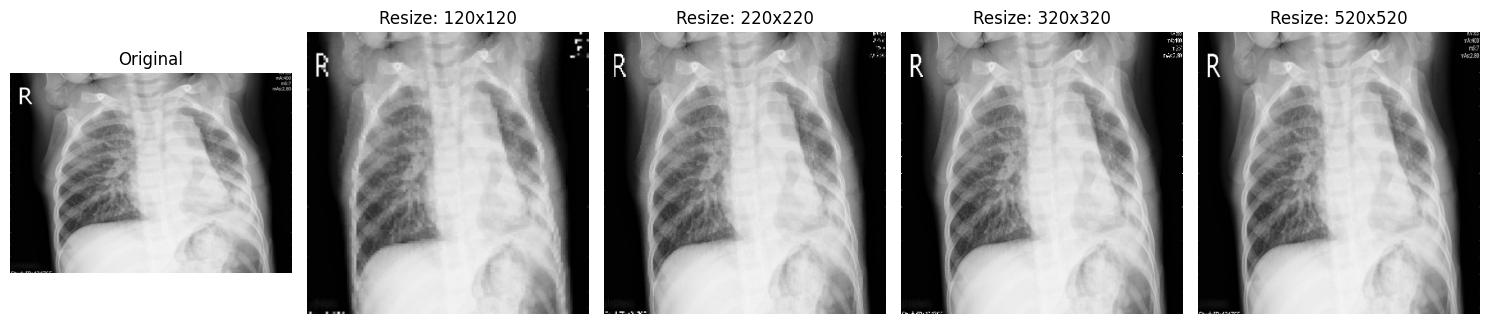

In [32]:
# Distintos tamaños a probar
sizes = [120, 220, 320, 520]

# Elegimos una imágen aleatoria para aplicarle los resizes
sample_pneumonia_image = random.choice(pneumonia_train_images)
img = cv2.imread(sample_pneumonia_image)

# Creamos una lista para almacenar las imágenes
images = []

# Agregamos la imagen original 
images.append(img)

for size in sizes:
  resized_img = resize_image(img, size, size)
  images.append(resized_img)

# Creamos una figura
plt.figure(figsize=(15, 15))


# Mostramos las imágenes con su tamaño
for i, (img, size) in enumerate(zip(images, [None] + sizes)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if size:
        plt.title(f'Resize: {size}x{size}')
    else:
        plt.title(f'Original')

# Ajustamos el diseño de la figura
plt.tight_layout()
plt.show()

In [33]:
# Definimos un tamaño para estandarizar las imágenes
size = 220

Estudiamos como afecta la cantidad de suavizado o ``blur`` para reducir el ruido en nuestra imágen.

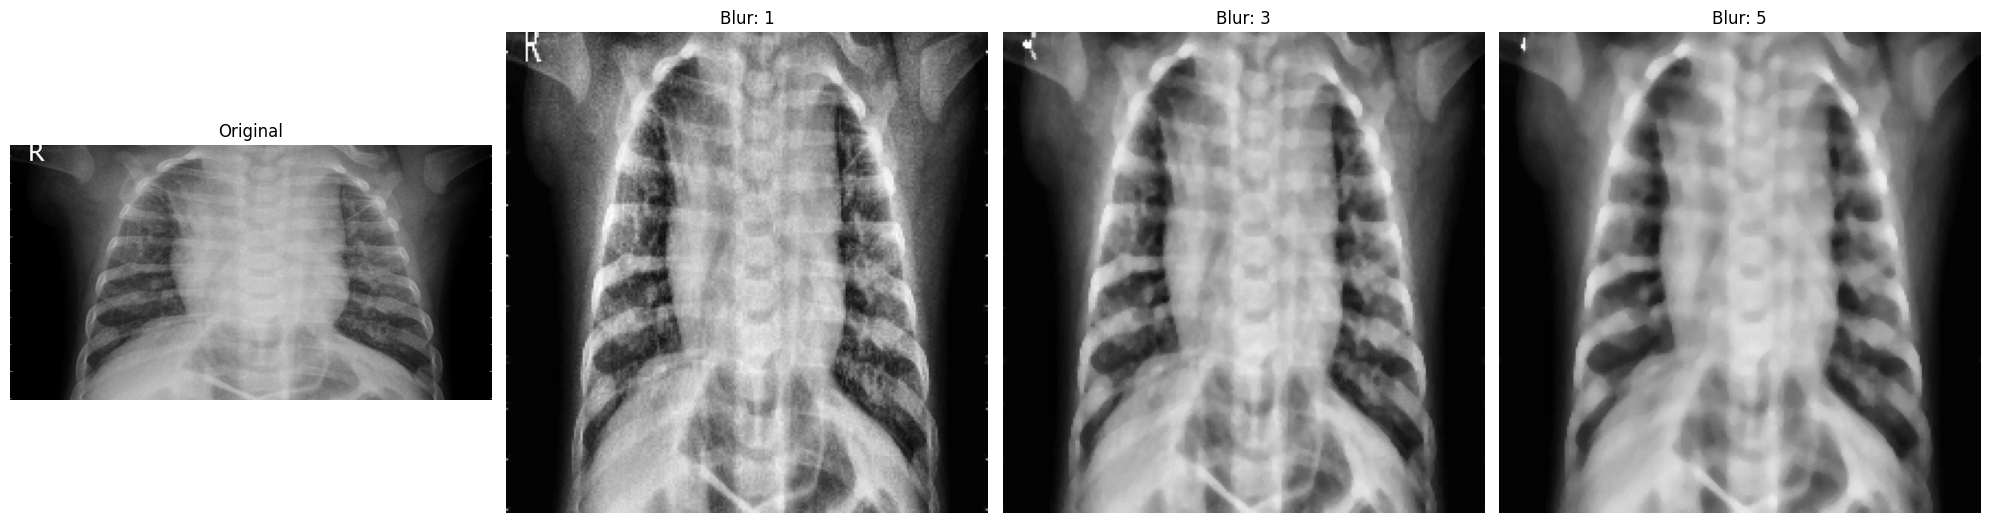

In [34]:
# Distintos blurs
blurs = [1, 3, 5]

# Elegimos una imágen aleatoria para aplicarle los blurs
sample_pneumonia_image = random.choice(pneumonia_train_images)
img = cv2.imread(sample_pneumonia_image)

# Creamos una lista para almacenar las imágenes
images = []

# Agregamos la imagen original 
images.append(img)

for blur in blurs:
  resized_img = resize_image(img, size, size)
  preprocessed_normal_image = preprocess_image(resized_img, blur, 2.0, 8)
  images.append(preprocessed_normal_image)

# Creamos una figura
plt.figure(figsize=(20, 20))


# Mostramos las imágenes con su blur
for i, (img, blur) in enumerate(zip(images, [None] + blurs)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if blur:
        plt.title(f'Blur: {blur}')
    else:
        plt.title(f'Original')

# Ajustamos el diseño de la figura
plt.tight_layout()
plt.show()

Estudiamos como afecta la cantidad de corrección de ``contraste`` a nuestra imágen.

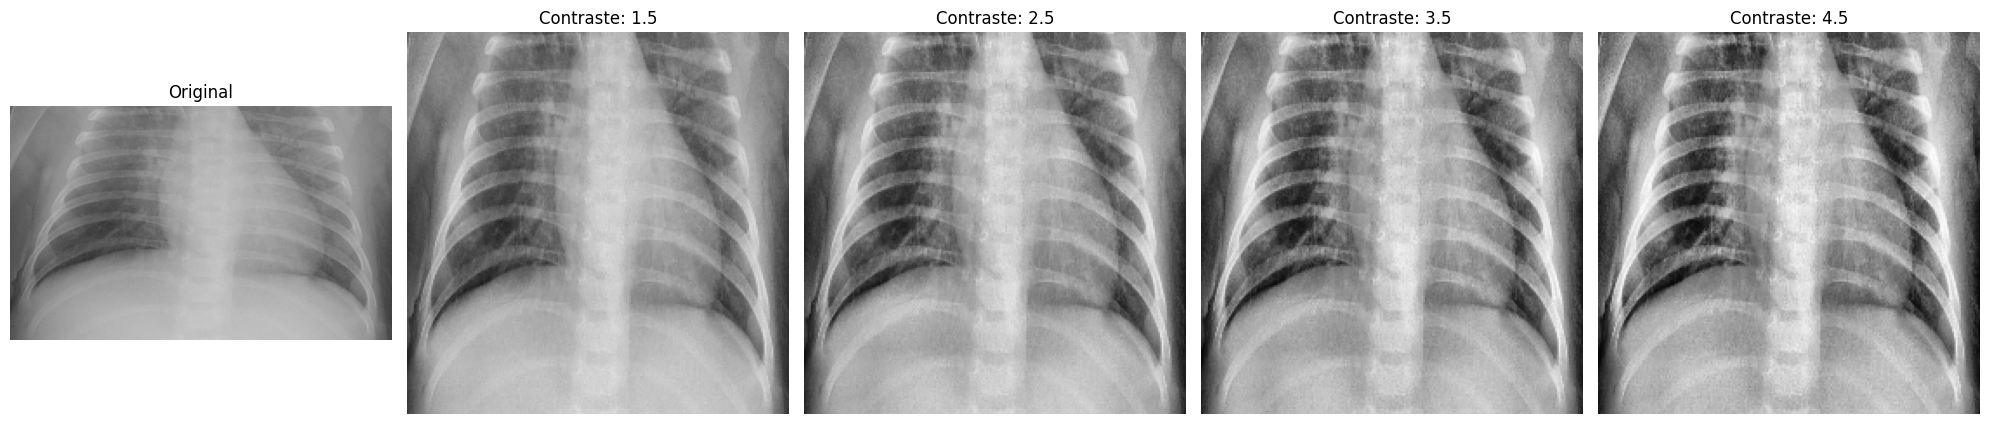

In [35]:
# Distintos contrastes
contrastes = [1.5, 2.5, 3.5, 4.5]

# Elegimos una imágen aleatoria para aplicarle los contrastes
sample_pneumonia_image = random.choice(pneumonia_train_images)
img = cv2.imread(sample_pneumonia_image)

# Creamos una lista para almacenar las imágenes
images = []

# Agregamos la imagen original 
images.append(img)

for contraste in contrastes:
  resized_img = resize_image(img, size, size)
  preprocessed_normal_image = preprocess_image(resized_img, 1, contraste, 8)
  images.append(preprocessed_normal_image)

# Creamos una figura
plt.figure(figsize=(20, 20))


# Mostramos las imágenes con su contraste
for i, (img, contraste) in enumerate(zip(images, [None] + contrastes)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if contraste:
        plt.title(f'Contraste: {contraste}')
    else:
        plt.title(f'Original')

# Ajustamos el diseño de la figura
plt.tight_layout()
plt.show()

Estudiamos como afecta el tamaño de los bloques en los que se divide la imagen para calcular la ecualización. A lo que denominaremos como ``grid``.

Un tamaño de bloque más grande puede suavizar el efecto de la ecualización del histograma, mientras que un tamaño de bloque más pequeño puede capturar mejor las variaciones locales en el contraste.

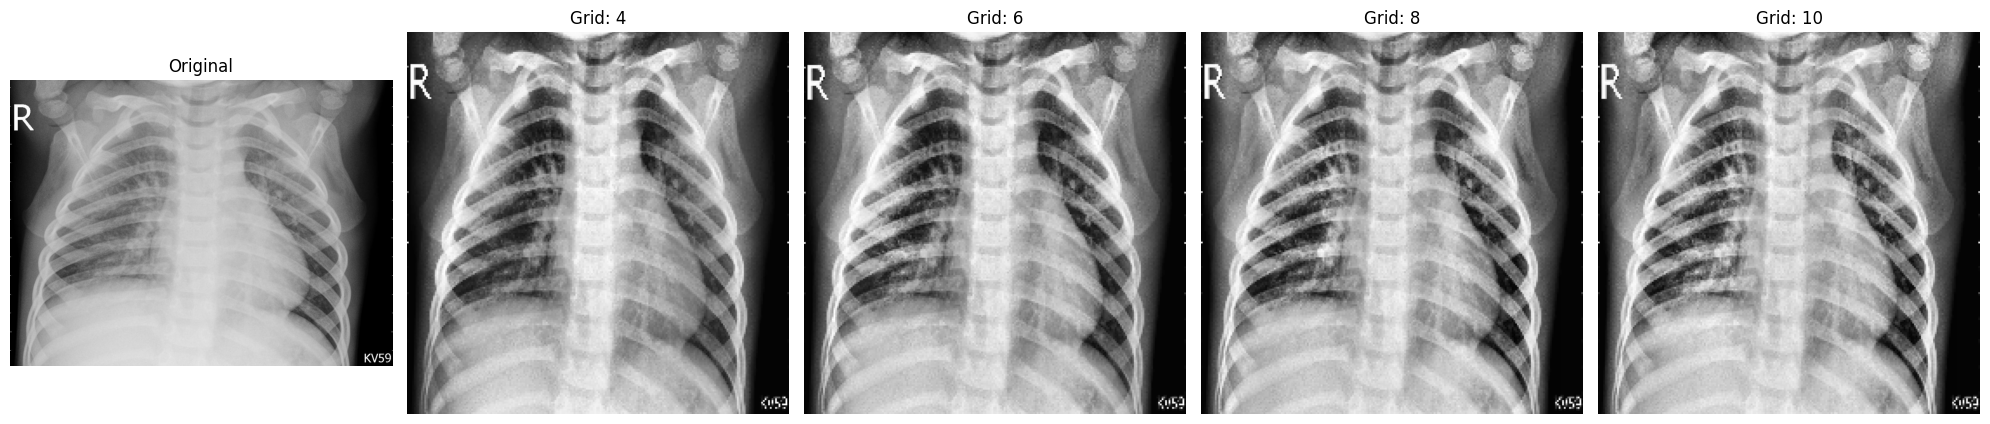

In [36]:
# Distintos tamaños de grid
grids = [4, 6, 8, 10]

# Elegimos una imágen aleatoria para aplicarle los tamaños de grid
sample_pneumonia_image = random.choice(pneumonia_train_images)
img = cv2.imread(sample_pneumonia_image)

# Creamos una lista para almacenar las imágenes
images = []

# Agregamos la imagen original 
images.append(img)

for grid in grids:
  resized_img = resize_image(img, size, size)
  preprocessed_normal_image = preprocess_image(resized_img, 1, 3.5, grid)
  images.append(preprocessed_normal_image)

# Creamos una figura
plt.figure(figsize=(20, 20))


# Mostramos las imágenes con su tamaños de grid
for i, (img, grid) in enumerate(zip(images, [None] + grids)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if grid:
        plt.title(f'Grid: {grid}')
    else:
        plt.title(f'Original')

# Ajustamos el diseño de la figura
plt.tight_layout()
plt.show()

Podemos realizar una observación completa con los parámetros que hemos estudiado antes comparandolos cada uno con sus versiones originales.

In [37]:
# Parámetros para el preprocesado
blur = 1
contraste = 3.5
grid = 6

# Número de muestras
num_samples = 2

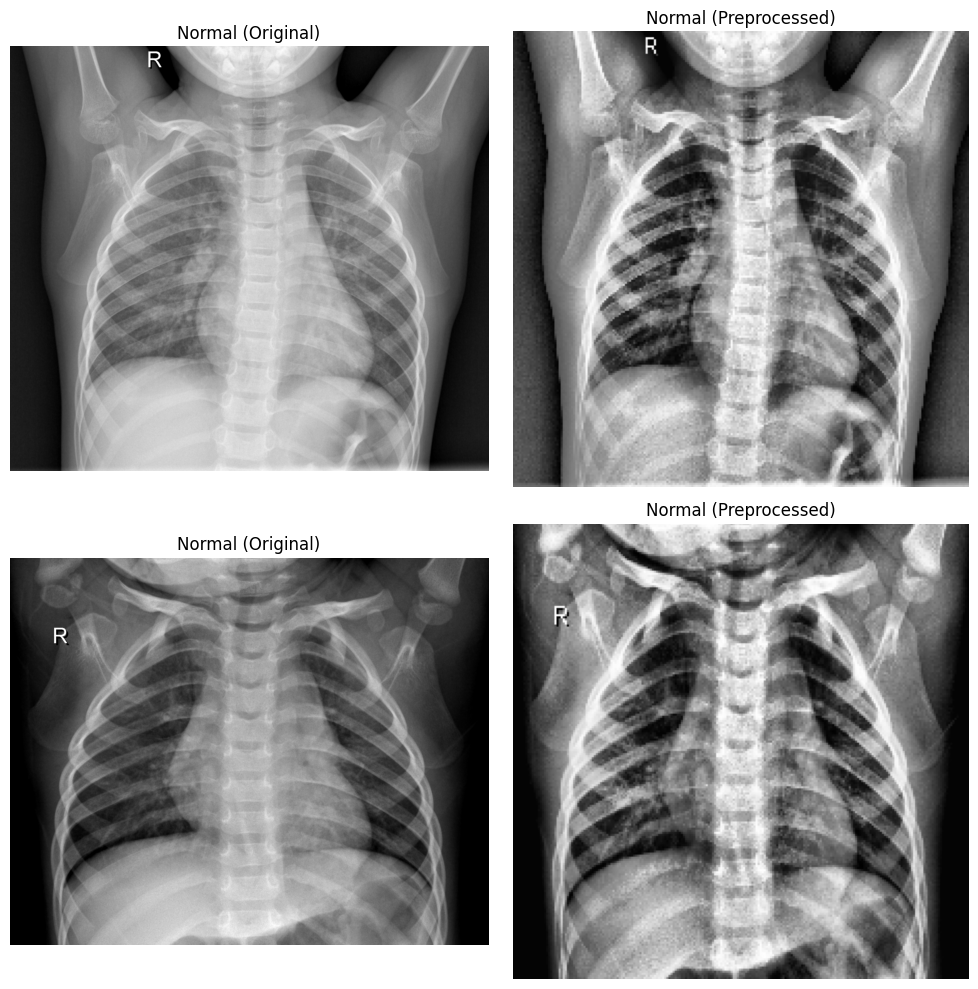

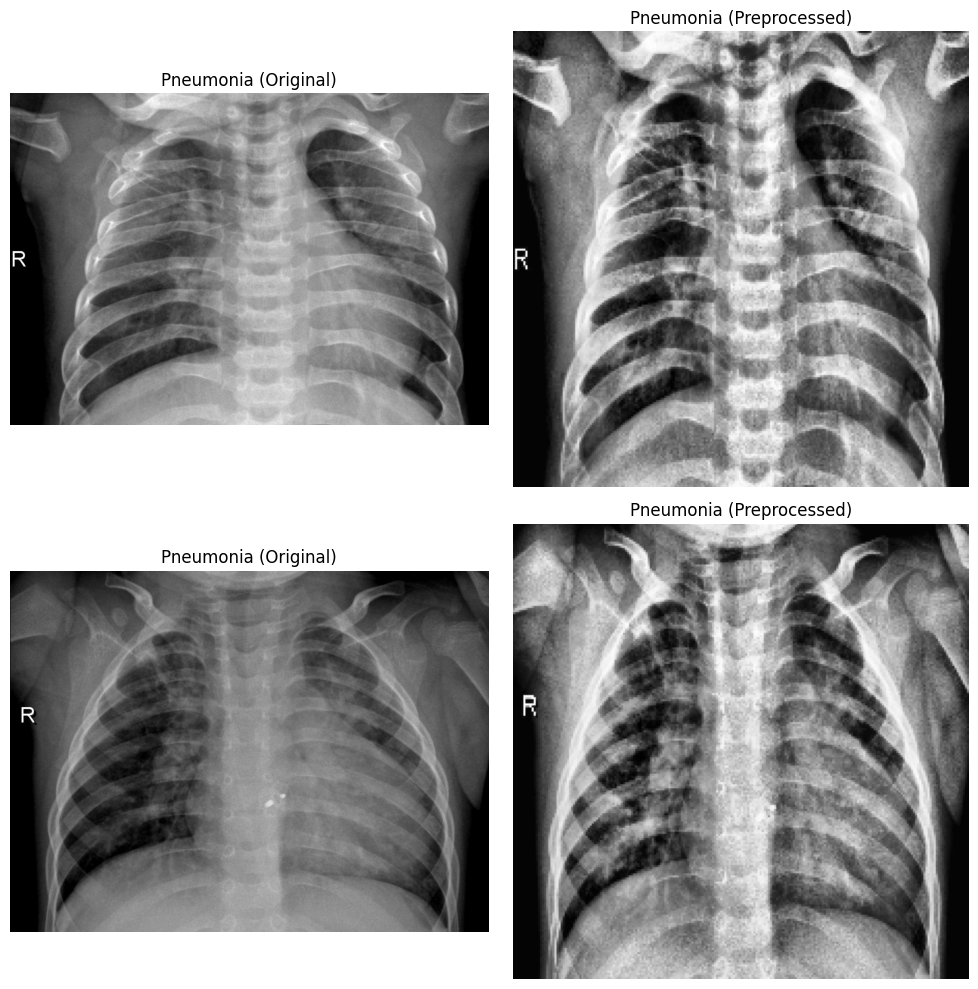

In [38]:


# Figura con las imágenes Normales
plt.figure(figsize=(10, 10))

for i in range(num_samples):
    sample_normal_image = normal_train_images[i]
    img = cv2.imread(sample_normal_image)
    
    # Original
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Normal (Original)')
    plt.axis('off')
    
    # Preprocess
    plt.subplot(num_samples, 2, 2*i + 2)
    resized_img = resize_image(img, size, size)
    preprocessed_normal_image = preprocess_image(resized_img, blur, contraste, grid)
    plt.imshow(cv2.cvtColor(preprocessed_normal_image, cv2.COLOR_BGR2RGB))
    plt.title('Normal (Preprocessed)')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Figura con las imágenes con Nuemonía
plt.figure(figsize=(10, 10))

for i in range(num_samples, num_samples*2):
    sample_pneumonia_image = pneumonia_train_images[i]
    img = cv2.imread(sample_pneumonia_image)
    
    # Original
    plt.subplot(num_samples, 2, 2*(i - num_samples) + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Pneumonia (Original)')
    plt.axis('off')
    
    # Preprocess
    plt.subplot(num_samples, 2, 2*(i - num_samples) + 2)
    resized_img = resize_image(img, size, size)
    preprocessed_pneumonia_image = preprocess_image(resized_img, blur, contraste, grid)
    plt.imshow(cv2.cvtColor(preprocessed_pneumonia_image, cv2.COLOR_BGR2RGB))
    plt.title('Pneumonia (Preprocessed)')
    plt.axis('off')

plt.tight_layout()
plt.show()

***4. Entrenamos el modelo***

**5. Metricas obtenidas**